## Notebook 1: Flow Measurement using the Salt Dilution Method

Go through this notebook and follow along with the calculation of discharge using the salt-dilution method.  At the end, there is an open ended question that requires you to reflect on the content of the notebook.  Written responses are to be submitted via Canvas, where a response field will be set up.

In [1]:
# import required packages
import pandas as pd
import numpy as np
import math

# plotting library
from matplotlib import pyplot as plt
# advanced statistics library
from scipy import stats

%matplotlib inline

### Given Information:

*(an example of a nicely formatted table using the Markdown notation)*

| Parameter | Value | Units |
|---|---|---|
| Date of Measurement | 26 September 2010 | -|
| Mass of Injected Salt | 100 | kg |
| Calibration Solution | 10.1 | $\frac{g}{L}$ |
| Calibration Volume | 500 | $mL$ |
| Calibration increments | 1.1 | $mL$ |

### Import the Salt Dilution Data

In a salt dilution measurement, we first calibrate the instrument.  The calibration data is provided in a file named *SD_cal.csv

In [2]:
data_file_path = '../data/notebook_1_data/'
calibration_filename = 'SD_cal.csv' # this is the calibration data file
salt_dilution_filename = 'SD_data.csv' # this is the measurement data file

In [3]:
# instrument calibration data
# see how two strings can be combined with the '+' operator
sd_cal = pd.read_csv(data_file_path + calibration_filename)
# discharge measurement data
sd_data = pd.read_csv(data_file_path + salt_dilution_filename)

# data given in the calibration file
cal_solution_concn = 10.1 # g/L - this is the NaCl concentration in the calibration solution
cal_vol = 500 # total calibration volume mL 
cal_vol_increment = 1.1 # [mL] increments for calibration solution

In [4]:
# display a preview of the calibration data
sd_cal

,Calibration volume (ml),Calibration solution added (ml),Salt added (mg),Concentration (mg/l),Conductivity (microSiemens/cm),Temperature (C)
0,500,0.0,0.0,0.0,303.0,10.8
1,NaN,1.0,NaN,NaN,343.0,10.8
2,NaN,2.0,NaN,NaN,380.0,10.8
3,NaN,3.0,NaN,NaN,426.0,10.8
4,NaN,4.0,NaN,NaN,464.0,10.8
5,NaN,5.0,NaN,NaN,505.0,10.8
6,NaN,6.0,NaN,NaN,546.0,10.8
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,Salt concentration of calibration solution is ...,NaN,NaN,NaN,NaN,NaN


In [5]:
# update the calibration solution added column for the volume of calibration solution added during the calibration
sd_cal['Calibration solution added (ml)'] = cal_vol_increment * sd_cal.index

#  add the volume of solution to the calibration volume
sd_cal['Calibration volume (ml)'] = cal_vol + sd_cal['Calibration solution added (ml)']

# calculate the equivalent salt mass added from the calibration solution volume
# and the calibration solution concentration.
sd_cal['Salt added (mg)'] = sd_cal['Calibration solution added (ml)'] * cal_solution_concn
sd_cal['Concentration (mg/l)'] = sd_cal['Salt added (mg)'] / (sd_cal['Calibration volume (ml)'] / 1000)

# drop empty rows
sd_cal.dropna(how='any', inplace=True)

In [6]:
# see how the calibration data has been updated
sd_cal

,Calibration volume (ml),Calibration solution added (ml),Salt added (mg),Concentration (mg/l),Conductivity (microSiemens/cm),Temperature (C)
0,500.0,0.0,0.00,0.000000,303.0,10.8
1,501.1,1.1,11.11,22.171223,343.0,10.8
2,502.2,2.2,22.22,44.245321,380.0,10.8
3,503.3,3.3,33.33,66.222929,426.0,10.8
4,504.4,4.4,44.44,88.104679,464.0,10.8
5,505.5,5.5,55.55,109.891197,505.0,10.8
6,506.6,6.6,66.66,131.583103,546.0,10.8


## Correct Conductivity for Temperature

The electrical conductivity (EC) of water is a function of temperature, so it is important that the water used for calibration is the same temperature as the water in the stream being measured.  Alternatively, a temperature correction can be applied.

Presented below are two different methods of temperature compensation.

The instrument used in both the calibration and the measurement already has temperature compensation within the instrument, so the values recorded are EC at 25 C. 

In [7]:
def eu_std_ect_adjust(temp, ec):
    """
    Takes in a temperature (Theta), and an EC value,
    returns a temperature adjusted ECT value
    based on EU standard 27888 conversion.
        Input:  -temperature (Celsius)
                -electrical conductivity
    """
    c1 = -0.198058
    c2 = -1.992186
    c3 = 231.17628
    c4 = 86.39123
    r = c1 + math.exp(c2 + c3 / (temp + c4))
    c5 = 0.962144
    c6 = 0.965078
    c7 = 1.116
    f25 = ((1 - c5) + c5 * (r**c6)) * c7
    return ec * f25

def linear2_ect_adjust(temp, ec):
    """
    Takes in a temperature (temp), and an EC value (ec),
    returns a temperature adjusted ECT value
    based on linear interpolation with 2% at 25 degrees.
    """
    f25 = 2.0
    return ec / (1 + (f25 /100) * (temp - 25))


In [8]:
# Apply temperature compensation to the measured conductivity

# Note, in this case, the data is already temperature compensated 
# so this is not needed, but in many cases it is not, so it is left 
# here for reference

temp_compensated = []
for i, row in sd_cal.iterrows():
    conductivity = row['Conductivity (microSiemens/cm)']
    temperature = row['Temperature (C)']

    # for each value in the conductivity time series,
    # apply the function to correct for temperature,
    # and add to the temp compensated array
    temp_ec = eu_std_ect_adjust(temp=temperature, ec=conductivity)
    
    temp_compensated.append(temp_ec)

# now add the temp_compensated array as a new column
# as stated above, this is left commented out as
# it is not needed in this case.
# sd_cal['ECT (us/cm)'] = temp_compensated


sd_cal

,Calibration volume (ml),Calibration solution added (ml),Salt added (mg),Concentration (mg/l),Conductivity (microSiemens/cm),Temperature (C)
0,500.0,0.0,0.00,0.000000,303.0,10.8
1,501.1,1.1,11.11,22.171223,343.0,10.8
2,502.2,2.2,22.22,44.245321,380.0,10.8
3,503.3,3.3,33.33,66.222929,426.0,10.8
4,504.4,4.4,44.44,88.104679,464.0,10.8
5,505.5,5.5,55.55,109.891197,505.0,10.8
6,506.6,6.6,66.66,131.583103,546.0,10.8


### Plot the calibration and best fit line

The calibration points are plotted with as red circles, which is represented in the call to the `plot` function by the two-character combination `ro`.  The best fit line through the calibration points is represented by a dashed blue line, specified by the three character code `b--`.  Changing the appearance of the plotted series is a matter of [looking up the short form](https://matplotlib.org/3.1.0/api/markers_api.html#module-matplotlib.markers).  

The `stats.linregress` function takes in two arrays and returns the equation of the best fit line through the data, along with information about the fit.  Note that the r-value is the correlation coefficient.  The coefficient of determination ($R^2$) is the correlation coefficient squared.

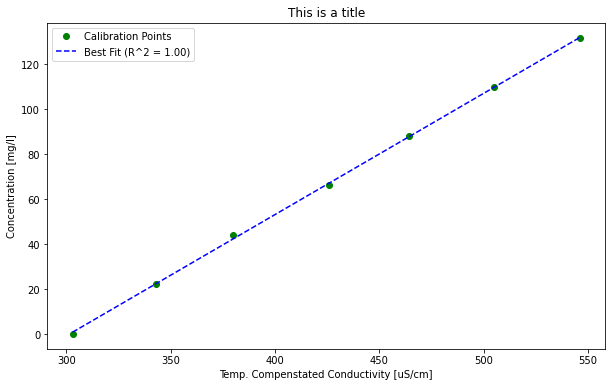

In [9]:
# initialize a single figure (the values 1, 1 can be changed to create a grid of plots)
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# the .to_numpy() attribute converts to a vector in order to do vector operations
cond_series = sd_cal['Conductivity (microSiemens/cm)'].to_numpy()
conc_series = sd_cal['Concentration (mg/l)'].to_numpy()

# add the calibration points to the plot
ax.plot(cond_series, conc_series, 'go', label="Calibration Points")

# plt.set_ylabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_xlabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_ylabel('Concentration [mg/l]')
ax.set_title('This is a title')

# the set_xlim and set_ylim attributes can be used to set the axis limits
# ax.set_xlim(right=400)
# ax.set_ylim(top=80)

# add best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(cond_series,
                                                                    conc_series)

#  create an array between the minimum and maximum calibration points
x_range = np.linspace(cond_series.min(), cond_series.max(),  100)

# use the best fit slope and intercept to construct the best fit line
best_fit = [x * slope + intercept for x in x_range]

# add the best fit line to the plot
ax.plot(x_range, best_fit, 'b--', label='Best Fit (R^2 = {:.2f})'.format(r_value**2))
# by default a legend is not shown, so we need to call the attribute.
plt.legend()

## Matplotlib is a good plotting library, but...

If you can imagine a function or feature you wish were already built, chances are it exists.  The Bokeh plotting library allows for a higher level of interactivity.  In the plot below, note the toolbar on the right hand side.  You can use the tools to take a closer look at your data in this simple case.  Plots can also be linked in Bokeh, with which powerful 'dashboards' can be built.  

In [10]:
from bokeh.plotting import figure, show, output_notebook
# specify the plot to output within the notebook and not in a new window
output_notebook()

# initialize the figure
p = figure(plot_width=800, plot_height=400)

# add a circle renderer with a size, color, and alpha
p.circle(cond_series, conc_series, size=5, color="red", alpha=0.5)
p.line(x_range, best_fit)

# show the results
show(p)

Loading BokehJS ...

### Best Fit slope and R<sup>2</sup> of calibration points

Below, the print statement is comprised of a string.  In ths string, the `{}` symbols appear twice where I want to insert input from two different variables.  In this case, the values inside the curly brackets `{:.2f}` means I want a **float** of **2** decimal places.  There are a number of ways to insert variable values in strings for output.  More information on string formatting can be [found here](https://www.python.org/dev/peps/pep-3101/).

The `\n` in the string breaks the line in the printed output.

In [11]:
#note: the number of decimals in the slope is too low. adjust the line below to print one more decimal.
print("The calibration best fit slope is {:.2f} [[mg/L] / [uS/cm]] \n and the coefficient of determination of the calibration is {}.".format(slope, 
                                                                                                                                         round(r_value**2, 3)))

The calibration best fit slope is 0.54 [[mg/L] / [uS/cm]] 
 and the coefficient of determination of the calibration is 1.0.


### Plot the measurement

Now we'll use the second data file.  Recall that the first file was for calibration.  The EC sensor was placed in a measured volume of water, and calibration solution was added in measured amounts to record the change in conductivity.  

For the actual measurement of flow in the creek, the EC sensor is placed in the creek some distance downstream of the where a known mass of salt is deposited and mixed.

Below we plot the conductivity over time, and we also determine what the 'background' conductivity was in order to calculate the area under the conductivity curve.  It turns out there is a lot of interesting information about runoff processes contained in the background EC signal.

In [12]:
sd_data

,Time (s),ECT (uS/cm),Temperature (C)
0,1,298,10.8
1,2,298,10.8
2,3,298,10.8
3,4,298,10.8
4,5,298,10.8
...,...,...,...
863,864,298,10.5
864,865,298,10.5
865,866,298,10.5
866,867,298,10.5


<AxesSubplot:xlabel='Time (s)'>

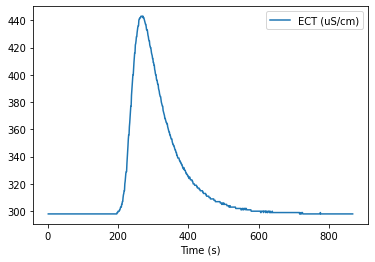

In [13]:
# we can also plot directly from a dataframe
sd_data.plot('Time (s)', 'ECT (uS/cm)')

In [14]:
# start and end time of the measurement (seconds)
# plot the data, and adjust measurement start and end times
msmt_start = 190
msmt_end = 700


In [15]:
# the background is the natural level of conductivity prior to the salt injection
start_bg = 0  # set the time (in seconds) for the start point of the background
end_bg = 150  # set the time (in seconds) for the end point of the background

# here, the mean of the background over a certain period is calculated as the representative background EC.T
background_ect = sd_data['ECT (uS/cm)'].iloc[start_bg: end_bg].mean()

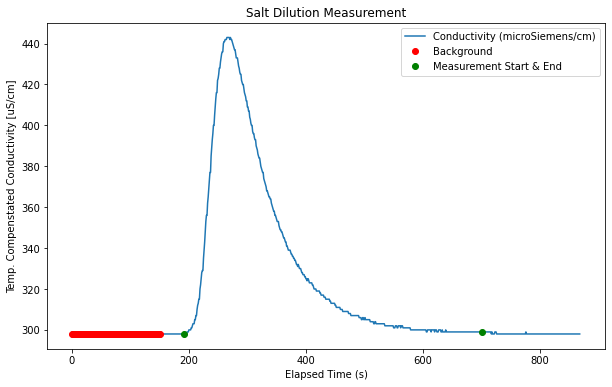

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# plot the conductivity vs. time
t = sd_data['Time (s)'].to_numpy()
ec_t = sd_data['ECT (uS/cm)'].to_numpy()

ax.plot(t, ec_t, label="Conductivity (microSiemens/cm)")

# label the axes, and set the plot title
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_title('Salt Dilution Measurement')

ax.plot(t[start_bg: end_bg], 
        ec_t[start_bg: end_bg], 'ro',
        label='Background')

ax.plot((t[msmt_start], t[msmt_end]),
        (ec_t[msmt_start], ec_t[msmt_end]), 'go',
        label='Measurement Start & End')

plt.legend()

### Calculate the Discharge

The volumetric flow (discharge) is equal to the area under the salt dilution curve, minus the background EC.

Calculate the area under the curve:

The area is: $$A_{curve} = \sum_{i=start}^{end} (ECT_i - ECT_{BG,i}) \cdot Slope_{calibration} \cdot t_{step,i} = \frac{\mu S}{cm} \cdot \frac {mg/L}{\mu S/cm} \cdot s = \frac {mg}{L} \cdot s$$
Then discharge (Q) is calculated by: $\frac{m_{salt}}{A_{curve}} = \frac{M\cdot kg \cdot \frac{1x10^6 mg}{1kg}}{\frac {mg}{L} \cdot \frac{1000 L}{1m^3} \cdot s} = \frac {m^3}{s}$

To illustrate, we are calculating the total area under the curve:

![Area under conductivity curve](img/a1.png)

And we are subtracting the rectangle representing the background.

![Background Area](img/a2.png)


In the cell below, we are calculating the area under the conductivity curve (`ECT (uS/cm`) and subtracting our background average determined above. 

Change the calculation so it only takes into account the part of the wave between the start and stop markers, i.e. `msmt_start` and `msmt_stop`.  

*Hint, how was the background average (`background_ect`) calculated previously?* 

In [ ]:
sd_data['t_elapsed'] = sd_data['Time (s)']

# subtract the background and multiply by the calibration slope 
sd_data['Concentration'] = (sd_data['ECT (uS/cm)'] - background_ect) * slope

time_step = 1 # the time step of the EC measurement device is 1s

# approximating the area under the curve as the sum of small rectangles
# of height 'concentration' and widths of 1 time step (1 second in this case)
conc_Area = sum(sd_data['Concentration'] * time_step)

mass = 1 # 1 kg salt was dumped in the river

# see the section above to convince yourself the units work out.
Q_calculated = mass * 1000 / conc_Area

print('The calculated discharge for the measurement is {:.2f} m^3/s'.format(Q_calculated))

## Questions to Consider

In this notebook, we demonstrated how a salt dilution measurement is processed, including calibration and calculation of volumetric flow.  There are a number of sources of uncertainty in this process.  Provide short written responses to the questions below.  It is recommended to use this notebook to get a sense of the sensitivity of the resulting volumetric flow calculation to various input parameters.

* Near the start of the notebook, we set variables associated with the calibration of the EC sensor:  
 * `cal_vol`: the volume of water from the stream used as the baseline for calibration,
 * `cal_solution_concn`: the concentration of our calibration solution, and 
 * `cal_vol_increment`: the incremental volume of calibration solution added to the calibration volume
 
### Question 1: 

Comment on the effect of errors in the *accuracy* of the three calibration variables.  Which variable results in the greatest change to the calculated discharge if the variable is changed by +/- 10%?

(i.e. what happens to the calculated discharge if our calibration solution is off by 1 mg/L?  What happens if we mislabel the container and instead of 10.1 mg/L we write 100.1 mg/L?)

### Question 2: 

Above, we manually set the start and end of the salt injection measurement (marked in the plot by the green dots) using the `msmt_start` and `msmt_end` variables.  In some flow conditions, the EC reading will take a very long time to return to baseline.  The realities of field work (time constraints, battery power, etc) occassionally result in the 'tail' of the measurement curve being cut off.  What happens to the calculated discharge if the EC measurement stops unexpectedly before the EC returns to baseline?  Go back in the notebook and change the `msmt_end` time and comment on the effect on the calculated discharge.